# **HOTEL BOOKING CANCELLATION ANALYSIS**
## **Comparison of Models: Logistic Regression, KNN, and Pre-Pruning Decision Tree**

# **High-Level Outline**

* [**Problem Definition**](https://github.com/AbelEsther/HOTEL-BOOKING-CANCELLATION-ANALYSIS?tab=readme-ov-file#problem-definition)
* [**Importance**](https://github.com/AbelEsther/HOTEL-BOOKING-CANCELLATION-ANALYSIS?tab=readme-ov-file#importance)
* [**Key Stakeholders**](https://github.com/AbelEsther/HOTEL-BOOKING-CANCELLATION-ANALYSIS?tab=readme-ov-file#key-stakeholders)
* [**Dataset Description**](https://github.com/AbelEsther/HOTEL-BOOKING-CANCELLATION-ANALYSIS?tab=readme-ov-file#dataset-description)



## Import necessary libraries

In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# EDA

## Open file dialog to upload CSV file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import csv file from drive
path="/content/drive/MyDrive/Colab Notebooks/hotel_bookings.csv"

In [ ]:
# Load the uploaded CSV file into a DataFrame
df=pd.read_csv(path)

In [ ]:
# Separate numerical and categorical variables
numerical_vars = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_vars = df.select_dtypes(include=['object']).columns.tolist()

print("\nNumerical variables:", numerical_vars)
print("Categorical variables:", categorical_vars)


Numerical variables: ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']
Categorical variables: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']


In [ ]:
# Display the DataFrame's information
print("\nDataFrame Info:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### **Streamline Dataset**
- Columns Dropped:
Company, Agent, Country

This streamlined dataset focuses on features most relevant to predicting booking cancellations.

In [ ]:
# Define important columns to keep
columns_to_keep = [
    'is_canceled',            # Target variable
    'lead_time',              # Booking lead time
    'arrival_date_year',      # Booking arrival year
    'arrival_date_month',     # Booking arrival month
    'arrival_date_week_number', # Booking arrival week number
    'stays_in_weekend_nights', # Weekend stay duration
    'stays_in_week_nights',    # Weekday stay duration
    'adults', 'children', 'babies', # Guest composition
    'meal',                   # Meal plan
    'market_segment',         # Booking source
    'distribution_channel',   # Booking distribution channel
    'is_repeated_guest',      # Whether the guest is a repeat customer
    'previous_cancellations', # History of cancellations
    'previous_bookings_not_canceled', # History of successful bookings
    'reserved_room_type',     # Room type initially reserved
    'assigned_room_type',     # Room type assigned
    'booking_changes',        # Changes made to booking
    'deposit_type',           # Deposit status
    'days_in_waiting_list',   # Time spent in the waiting list
    'customer_type',          # Type of customer
    'adr',                    # Average daily rate
    'total_of_special_requests' # Number of special requests
]


# Filter the dataset to include only the specified columns
df= df[columns_to_keep]

# Display the first few rows of the filtered dataset
df.head()

is_canceled  lead_time  arrival_date_year arrival_date_month  \
0            0        342               2015               July   
1            0        737               2015               July   
2            0          7               2015               July   
3            0         13               2015               July   
4            0         14               2015               July   

   arrival_date_week_number  stays_in_weekend_nights  stays_in_week_nights  \
0                        27                        0                     0   
1                        27                        0                     0   
2                        27                        0                     1   
3                        27                        0                     1   
4                        27                        0                     2   

   adults  children  babies  ... previous_cancellations  \
0       2       0.0       0  ...                      0   
1       2       0.0       0  ...                      0   
2       1       0.0       0  ...                      0   
3       1       0.0       0  ...                      0   
4       2       0.0       0  ...                      0   

  previous_bookings_not_canceled reserved_room_type  assigned_room_type  \
0                              0                  C                   C   
1                              0                  C                   C   
2                              0                  A                   C   
3                              0                  A                   A   
4                              0                  A                   A   

   booking_changes  deposit_type days_in_waiting_list customer_type   adr  \
0                3    No Deposit                    0     Transient   0.0   
1                4    No Deposit                    0     Transient   0.0   
2                0    No Deposit                    0     Transient  75.0   
3                0    No Deposit                    0     Transient  75.0   
4                0    No Deposit                    0     Transient  98.0   

  total_of_special_requests  
0                         0  
1                         0  
2                         0  
3                         0  
4                         1  

[5 rows x 24 columns]

## Descriptive Exploration
To understand the overall distribution and summary of the dataset, we'll display the basic summary statistics for each feature.

In [ ]:
# Display summary statistics
print("\nSummary Statistics:\n", df.describe())

# summarize the data
df.describe()


Summary Statistics:
          is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  stays_in_weekend_nights  \
count             119390.000000            119390.000000   
mean                  27.165173                 0.927599   
std                   13.605138                 0.998613   
min                    1.000000                 0.000000   
25%                   16.000000                 0.000000   
50%                   28.000000                 1.000000   
75%                   38.000000    

is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.156554   
std         0.482918     106.863097           0.707476   
min         0.000000       0.000000        2015.000000   
25%         0.000000      18.000000        2016.000000   
50%         0.000000      69.000000        2016.000000   
75%         1.000000     160.000000        2017.000000   
max         1.000000     737.000000        2017.000000   

       arrival_date_week_number  stays_in_weekend_nights  \
count             119390.000000            119390.000000   
mean                  27.165173                 0.927599   
std                   13.605138                 0.998613   
min                    1.000000                 0.000000   
25%                   16.000000                 0.000000   
50%                   28.000000                 1.000000   
75%                   38.000000                 2.000000   
max                   53.000000                19.000000   

       stays_in_week_nights         adults       children         babies  \
count         119390.000000  119390.000000  119386.000000  119390.000000   
mean               2.500302       1.856403       0.103890       0.007949   
std                1.908286       0.579261       0.398561       0.097436   
min                0.000000       0.000000       0.000000       0.000000   
25%                1.000000       2.000000       0.000000       0.000000   
50%                2.000000       2.000000       0.000000       0.000000   
75%                3.000000       2.000000       0.000000       0.000000   
max               50.000000      55.000000      10.000000      10.000000   

       is_repeated_guest  previous_cancellations  \
count      119390.000000           119390.000000   
mean            0.031912                0.087118   
std             0.175767                0.844336   
min             0.000000                0.000000   
25%             0.000000                0.000000   
50%             0.000000                0.000000   
75%             0.000000                0.000000   
max             1.000000               26.000000   

       previous_bookings_not_canceled  booking_changes  days_in_waiting_list  \
count                   119390.000000    119390.000000         119390.000000   
mean                         0.137097         0.221124              2.321149   
std                          1.497437         0.652306             17.594721   
min                          0.000000         0.000000              0.000000   
25%                          0.000000         0.000000              0.000000   
50%                          0.000000         0.000000              0.000000   
75%                          0.000000         0.000000              0.000000   
max                         72.000000        21.000000            391.000000   

                 adr  total_of_special_requests  
count  119390.000000              119390.000000  
mean      101.831122                   0.571363  
std        50.535790                   0.792798  
min        -6.380000                   0.000000  
25%        69.290000                   0.000000  
50%        94.575000                   0.000000  
75%       126.000000                   1.000000  
max      5400.000000                   5.000000

### Class distribution for the target variable 'is_canceled'

Explore key features and their relationship with the target variable.

             Count  Proportion
is_canceled                   
0            75166    0.629584
1            44224    0.370416


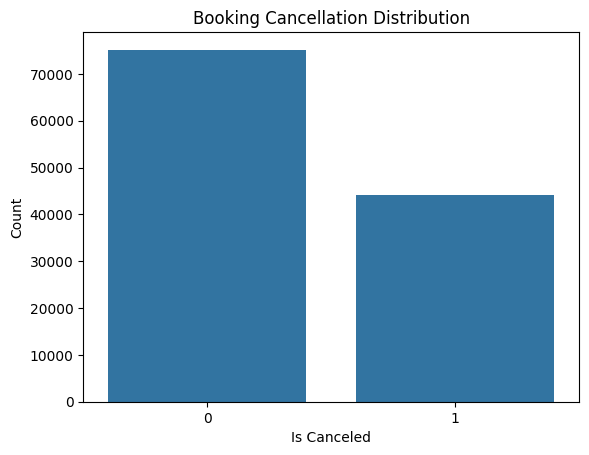

In [ ]:
counts = df['is_canceled'].value_counts()
proportions = df['is_canceled'].value_counts(normalize=True)

# Combine counts and proportions into a single DataFrame
count_proportion_df = pd.DataFrame({
    'Count': counts,
    'Proportion': proportions
})

# Display the DataFrame
print(count_proportion_df)

# Show the count plot, using 'df' instead of 'data_filtered'
sns.countplot(x='is_canceled', data=df)
plt.title('Booking Cancellation Distribution')
plt.xlabel('Is Canceled')
plt.ylabel('Count')
plt.show()


## Data Cleaning
Handle missing value and duplicated data

### Handling Missing Data

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Drop columns with more than 500 missing values
columns_to_drop = missing_values[missing_values > 500].index
df = df.drop(columns=columns_to_drop, axis=1)

# Drop rows with small missing values
df = df.dropna()

# Confirm there are no more missing values
df.isnull().sum()

is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
total_of_special_requests         0
dtype: int64

### Handling Duplicate Data
Before moving forward, I will check for and handle any duplicate records in the dataset. Duplicates can lead to biased model results by over-representing certain cars. Removing duplicates ensures that the model is trained on unique records only.

In [ ]:
# Check for Duplicate Data
duplicate_data = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_data)

# Step 4: Handle Duplicate Data
df = df.drop_duplicates()

# Verify duplicates are removed
print("Number of duplicate rows after removal:", df.duplicated().sum())

# summarize the data
df.describe()

Number of duplicate rows: 34430
Number of duplicate rows after removal: 0


is_canceled     lead_time  arrival_date_year  \
count  84956.000000  84956.000000       84956.000000   
mean       0.278874     79.434754        2016.214935   
std        0.448448     85.404265           0.685071   
min        0.000000      0.000000        2015.000000   
25%        0.000000     11.000000        2016.000000   
50%        0.000000     49.000000        2016.000000   
75%        1.000000    124.000000        2017.000000   
max        1.000000    737.000000        2017.000000   

       arrival_date_week_number  stays_in_weekend_nights  \
count              84956.000000             84956.000000   
mean                  26.834138                 1.012218   
std                   13.655674                 1.034451   
min                    1.000000                 0.000000   
25%                   16.000000                 0.000000   
50%                   27.000000                 1.000000   
75%                   37.000000                 2.000000   
max                   53.000000                19.000000   

       stays_in_week_nights        adults      children        babies  \
count          84956.000000  84956.000000  84956.000000  84956.000000   
mean               2.639743      1.882739      0.142015      0.011100   
std                2.062064      0.627690      0.460858      0.115051   
min                0.000000      0.000000      0.000000      0.000000   
25%                1.000000      2.000000      0.000000      0.000000   
50%                2.000000      2.000000      0.000000      0.000000   
75%                4.000000      2.000000      0.000000      0.000000   
max               50.000000     55.000000     10.000000     10.000000   

       is_repeated_guest  previous_cancellations  \
count       84956.000000            84956.000000   
mean            0.040021                0.031004   
std             0.196009                0.374018   
min             0.000000                0.000000   
25%             0.000000                0.000000   
50%             0.000000                0.000000   
75%             0.000000                0.000000   
max             1.000000               26.000000   

       previous_bookings_not_canceled  booking_changes  days_in_waiting_list  \
count                    84956.000000     84956.000000          84956.000000   
mean                         0.189145         0.271870              0.670476   
std                          1.756247         0.731121              9.476840   
min                          0.000000         0.000000              0.000000   
25%                          0.000000         0.000000              0.000000   
50%                          0.000000         0.000000              0.000000   
75%                          0.000000         0.000000              0.000000   
max                         72.000000        21.000000            391.000000   

                adr  total_of_special_requests  
count  84956.000000               84956.000000  
mean     106.786079                   0.706118  
std       55.358784                   0.834217  
min       -6.380000                   0.000000  
25%       72.250000                   0.000000  
50%       99.000000                   1.000000  
75%      135.000000                   1.000000  
max     5400.000000                   5.000000

### Handle outliners

<Axes: title={'center': 'With Outliers'}>

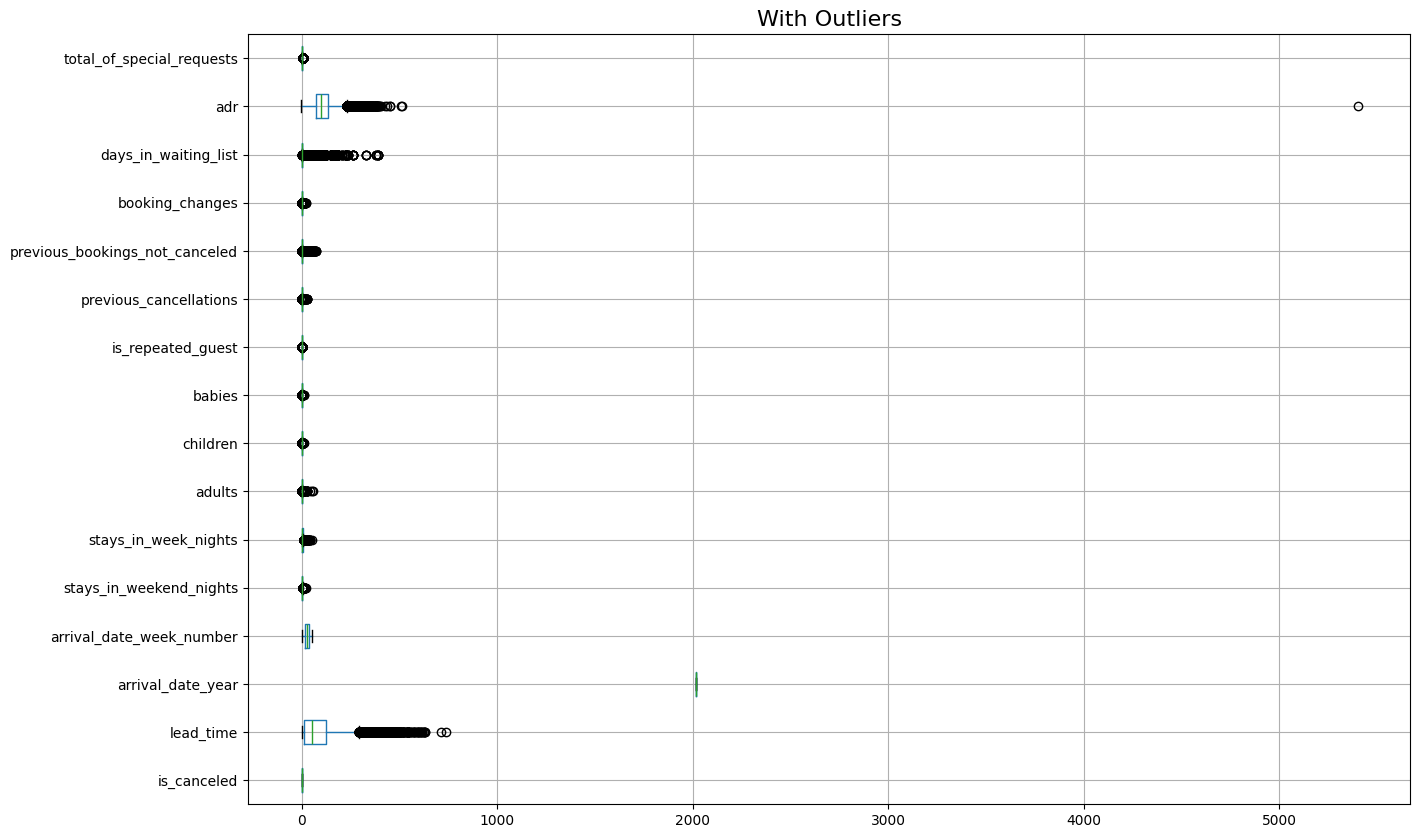

In [ ]:
plt.figure(figsize=(15,10))
plt.title('With Outliers',fontsize=16)
df.boxplot(vert=0)

## Charts To Analyze Data

### Heat map- Correlation analysis

In [ ]:
import plotly.express as px

# Select only numerical features for correlation analysis
numerical_df = df.select_dtypes(include=np.number)

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

# Create an interactive heatmap using Plotly
fig = px.imshow(
    correlation_matrix,
    labels=dict(x="Features", y="Features", color="Correlation"),
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    color_continuous_scale="Blues",
    zmin=-1, zmax=1,
    title="Interactive Correlation Heatmap"
)

# Update layout for better readability
fig.update_layout(
    title_font_size=18,
    xaxis_tickangle=45,
    xaxis_title="Features",
    yaxis_title="Features",
    width=800,
    height=700
)

# Show the interactive heatmap
fig.show()


In [ ]:
# Calculate correlations
corr = df.corr(method='pearson', numeric_only=True)['is_canceled'][:]
corr

is_canceled                       1.000000
lead_time                         0.189558
arrival_date_year                 0.086160
arrival_date_week_number          0.001966
stays_in_weekend_nights           0.057638
stays_in_week_nights              0.080743
adults                            0.076531
children                          0.065293
babies                           -0.021897
is_repeated_guest                -0.092155
previous_cancellations            0.050069
previous_bookings_not_canceled   -0.053583
booking_changes                  -0.092990
days_in_waiting_list              0.005772
adr                               0.126519
total_of_special_requests        -0.124548
Name: is_canceled, dtype: float64

**Ploting Lead Time against is_canceled**

In [ ]:
import plotly.express as px

# Create an interactive histogram using Plotly
fig = px.histogram(
    df,
    x='lead_time',
    color='is_canceled',
    nbins=30,
    barmode='overlay',
    labels={'lead_time': 'Lead Time', 'is_canceled': 'Booking Canceled'},
    title='Distribution of Lead Time by Booking Cancellation Status',
    color_discrete_map={0: 'blue', 1: 'orange'}
)

# Customize the layout
fig.update_layout(
    xaxis_title="Lead Time (days)",
    yaxis_title="Count",
    legend_title="Is Canceled",
    width=800,
    height=500
)

# Show the interactive plot
fig.show()

Maximum cancelations occur if the booking is made 0-49 days before the checkin date. Longer the lead_time, lower is the cancelation.

**ADR Distribution and Cancellation Status**

In [ ]:
import plotly.express as px

# Interactive box plot to segment ADR by market_segment and cancellation status
fig_market_segment = px.box(
    df,
    x='market_segment',
    y='adr',
    color='is_canceled',
    labels={
        'adr': 'Average Daily Rate (ADR)',
        'is_canceled': 'Booking Canceled',
        'market_segment': 'Market Segment'
    },
    title='ADR Distribution by Market Segment and Cancellation Status',
    color_discrete_sequence=['blue', 'orange']
)

# Customize layout
fig_market_segment.update_layout(
    xaxis_title="Market Segment",
    yaxis_title="ADR (Average Daily Rate)",
    legend_title="Is Canceled (0 = No, 1 = Yes)",
    width=1000,
    height=600
)

# Show the interactive plot for market_segment
fig_market_segment.show()

# Interactive box plot to segment ADR by customer_type and cancellation status
fig_customer_type = px.box(
    df,
    x='customer_type',
    y='adr',
    color='is_canceled',
    labels={
        'adr': 'Average Daily Rate (ADR)',
        'is_canceled': 'Booking Canceled',
        'customer_type': 'Customer Type'
    },
    title='ADR Distribution by Customer Type and Cancellation Status',
    color_discrete_sequence=['blue', 'orange']
)

# Customize layout
fig_customer_type.update_layout(
    xaxis_title="Customer Type",
    yaxis_title="ADR (Average Daily Rate)",
    legend_title="Is Canceled (0 = No, 1 = Yes)",
    width=1000,
    height=600
)

# Show the interactive plot for customer_type
fig_customer_type.show()


The **ADR Distribution by Market Segment** reveals that segments like **Online Travel Agents (OTA)** and **Offline TA/TO (Tour Operators)** exhibit high ADR variability and significant cancellation rates, reflecting the impact of dynamic pricing and flexible cancellation policies. Conversely, **Direct** and **Corporate bookings** show more stable ADR values and lower cancellation rates, highlighting greater customer commitment. The **ADR Distribution by Customer Type** shows that **Transient customers** have the widest ADR range and the highest cancellation rates, indicating sensitivity to price changes and flexibility. On the other hand, **Contract** and **Group customers** demonstrate lower ADR variability and fewer cancellations, suggesting their bookings are often pre-negotiated and more stable. These insights emphasize the need for tailored pricing strategies and cancellation policies for different customer types and market segments to optimize revenue and reduce cancellations.

### Boxplots of Numerical Features Categorized by Booking Cancellation Status

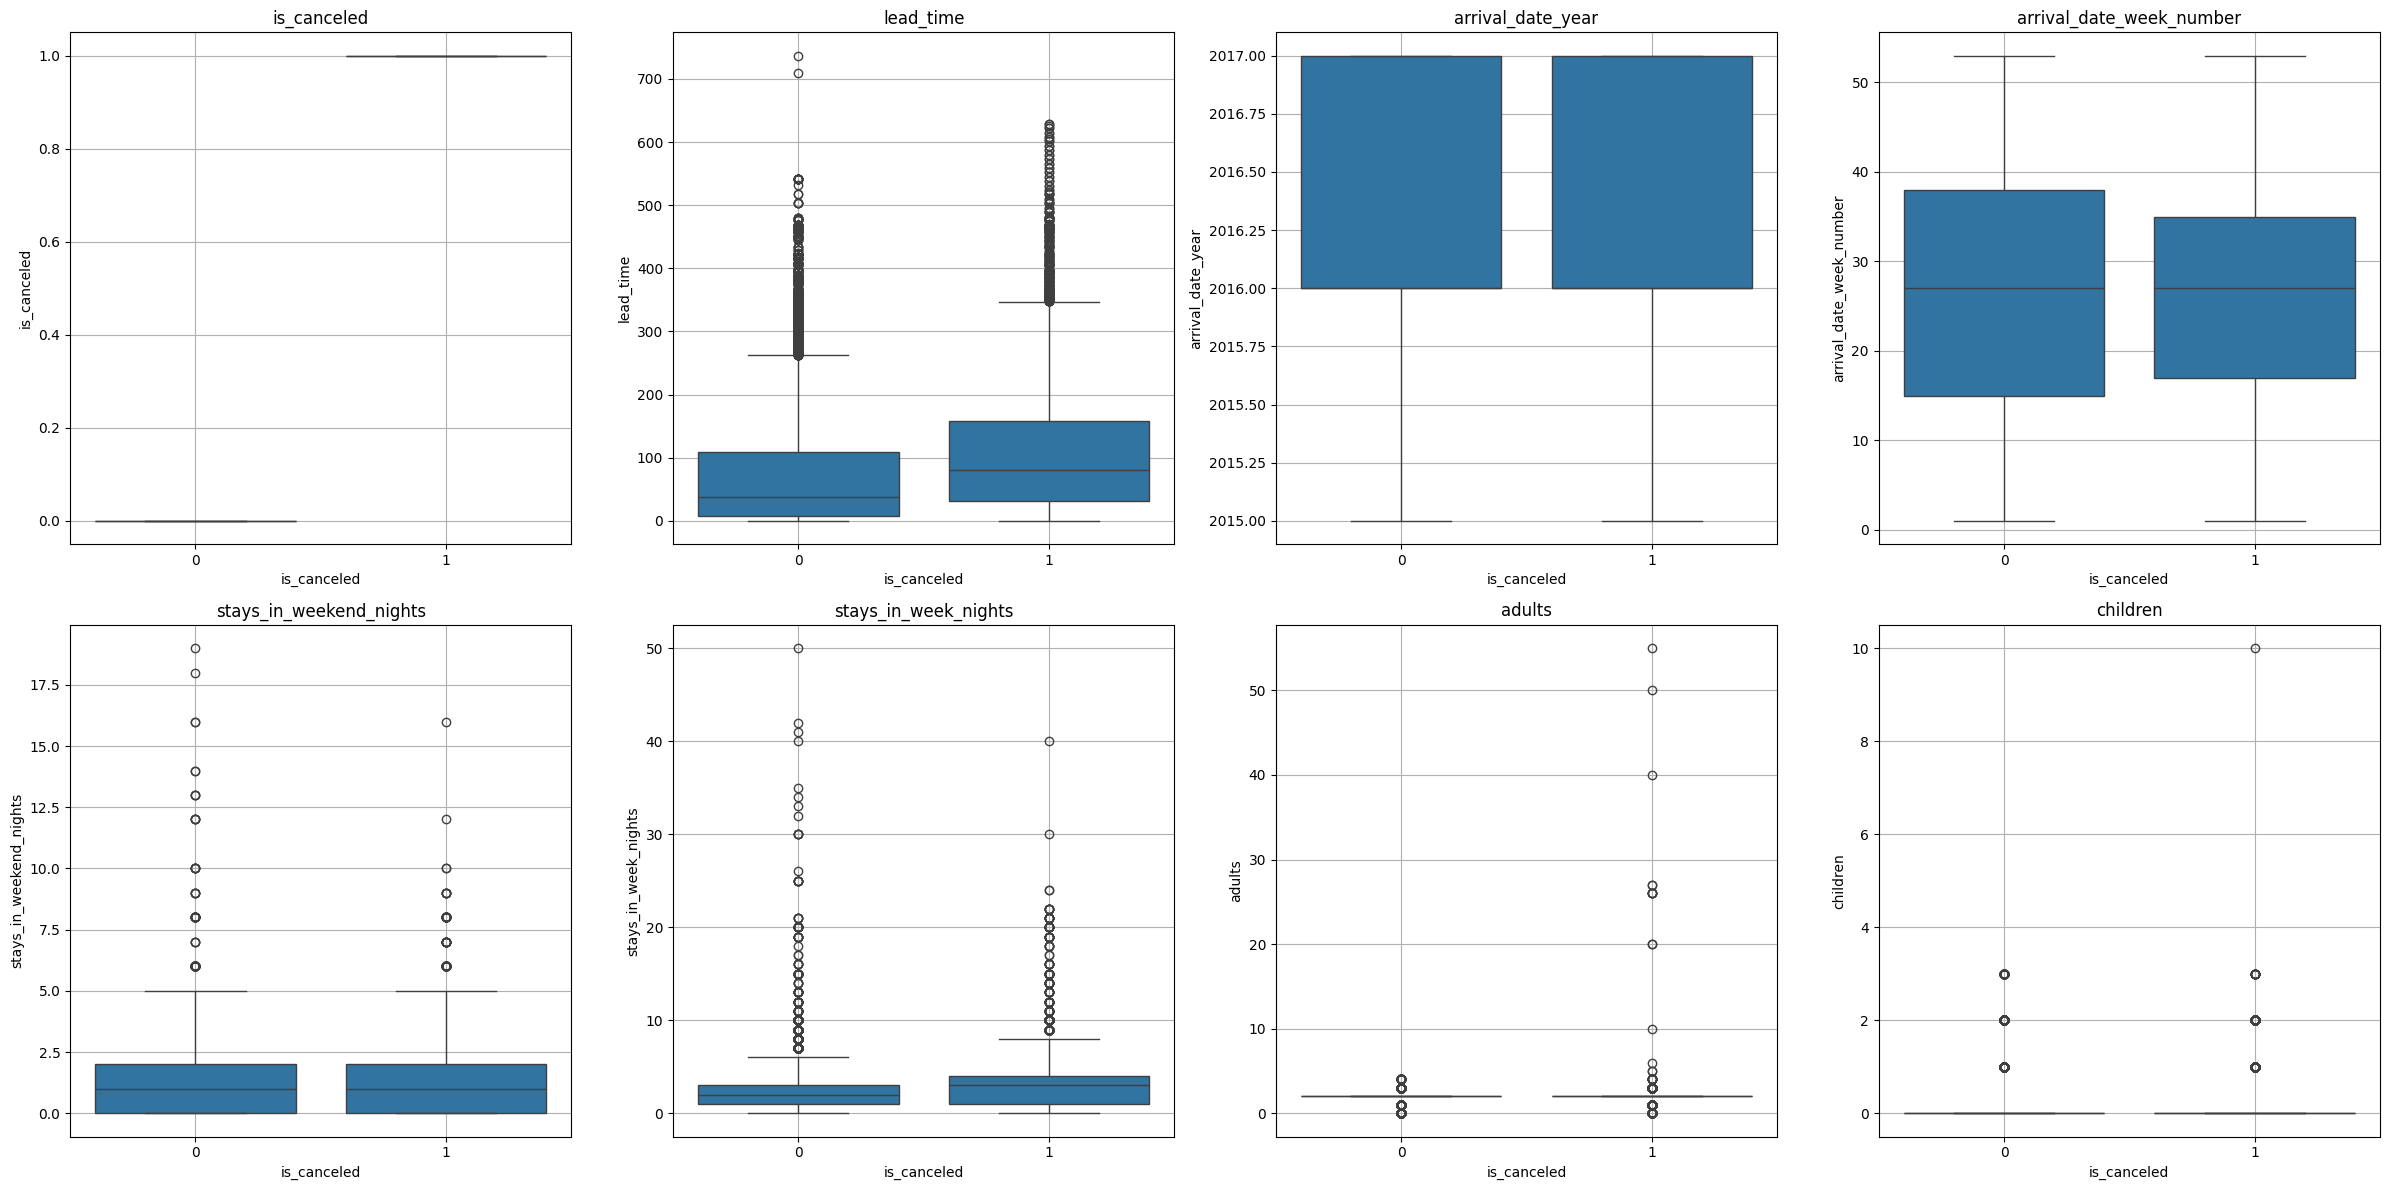

In [ ]:
# Example categorical variable for x-axis (e.g., 'is_canceled')
x_column = 'is_canceled'

# Create a figure for subplots
fig = plt.figure(figsize=(24, 12))

# Limit the number of numerical columns to visualize
num_columns = min(len(df.select_dtypes(include=np.number).columns), 8)

# Plot boxplots for the first 8 numerical features
for i, column in enumerate(df.select_dtypes(include=np.number).columns[:num_columns]):
    ax = fig.add_subplot(2, 4, i + 1)  # Add subplot to the grid
    sns.boxplot(x=x_column, y=column, data=df, ax=ax)  # Create boxplot
    ax.set_title(column)  # Set title for the subplot
    ax.grid()  # Add grid

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

##Transforming: Convert categorical variables to numerical variables

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# List of categorical columns to encode
categorical_columns = ['meal', 'deposit_type', 'arrival_date_month', 'customer_type','market_segment', 'distribution_channel' ]

# Keep a copy of the original DataFrame for alignment
original_df = df.copy()

# One-Hot Encoder setup
onehot_encoder = OneHotEncoder(sparse_output=False, drop=None)  # Dense output, keep all categories

# Apply one-hot encoding to all categorical columns
encoded_features = onehot_encoder.fit_transform(df[categorical_columns])

# Convert the encoded array into a DataFrame with appropriate column names
encoded_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out(categorical_columns))

# Reset index of the encoded DataFrame for alignment
encoded_df.reset_index(drop=True, inplace=True)

# Drop the original categorical columns from the original DataFrame
df = df.drop(columns=categorical_columns).reset_index(drop=True)

# Concatenate the one-hot encoded columns to the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Display the first few rows of the updated DataFrame
print(df.head())

   is_canceled  lead_time  arrival_date_year  arrival_date_week_number  \
0            0        342               2015                        27   
1            0        737               2015                        27   
2            0          7               2015                        27   
3            0         13               2015                        27   
4            0         14               2015                        27   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     0       2       0.0       0   
1                        0                     0       2       0.0       0   
2                        0                     1       1       0.0       0   
3                        0                     1       1       0.0       0   
4                        0                     2       2       0.0       0   

   is_repeated_guest  ...  market_segment_Corporate  market_segment_Direct  \
0       

## Feature selection and normalize Data


### Identify the Best Features Using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define features and target
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

# Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_encoded, y)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)
print("Feature Importances:")
print(importances.head(10))

Feature Importances:
lead_time                    0.209124
adr                          0.148617
arrival_date_week_number     0.094799
stays_in_week_nights         0.070520
total_of_special_requests    0.068011
stays_in_weekend_nights      0.044969
arrival_date_year            0.025623
market_segment_Online TA     0.024084
booking_changes              0.021835
adults                       0.021744
dtype: float64


Let's pick 4 features from the dataset (lead_time, adr,arrival_date_week_number, is_canceled).

The features **lead_time**, **adr**, and **arrival_date_week_number** were selected because they have the highest importance scores in the decision tree model. These features contribute significantly to predicting cancellations:

- **lead_time**: The most critical feature, as longer lead times correlate with higher cancellation rates.
- **adr**: High ADR values can influence cancellations, especially for price-sensitive customers.
- **arrival_date_week_number**: Reflects seasonal trends that impact cancellation behavior.

These features were chosen for their strong predictive power and practical relevance in understanding and managing booking cancellations.





In [ ]:
from sklearn.model_selection import train_test_split

# Define the features (X) and target variable (Y)
X = df[['lead_time', 'adr', 'arrival_date_week_number']]
Y = df['is_canceled']

## Train-Test Split
Split the data into training and testing sets.
- Split the data into training and test sets
- test_size=0.2 indicates that 20% of the data will be used for testing, and the rest for training
- random_state=42 ensures reproducibility of the split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Print the shapes of the resulting sets to verify the split
print('Train set:', X_train.shape, Y_train.shape)
print('Test set:', X_test.shape, Y_test.shape)

Train set: (67964, 3) (67964,)
Test set: (16992, 3) (16992,)


# Model

## 3.1 Decision Tree Construction
Task: Build a decision tree classifier.
- Draw the tree: Constrain the tree’s max_depth (e.g., 5 or 7) to ensure the tree is drawable.
- Show confusion matrix, accuracy, precision, recall, and f1 score.
- Show and plot feature importance.
- Show and plot precision_recall curve, and ROC curve.
- Use cross-validation (k=10) to show average accuracy.

In [ ]:
# Check for Missing Data
missing_data = df.isnull().sum()
print("Missing data in each column:\n", missing_data)


print(df.describe())

Missing data in each column:
 is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_week_number          0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
days_in_waiting_list              0
adr                               0
total_of_special_requests         0
meal_BB                           0
meal_FB                           0
meal_HB                           0
meal_SC                           0
meal_Undefined                    0
deposit_type_No Deposit           0
deposit_type_Non Refund           0
deposit_type_Refundable           0
arrival_date_month_April          

### **a. Classification (Decision Tree)**
The **DecisionTreeClassifier** is a machine learning algorithm provided by scikit-learn that is used for both classification and regression tasks, though it is more commonly used for classification. The algorithm works by splitting the dataset into subsets based on the most significant attribute, forming a tree-like model of decisions. Each internal node of the tree represents a "test" on an attribute, each branch represents the outcome of the test, and each leaf node represents a class label (for classification).

- criterion: ('gini' or 'entropy') Function to measure the quality of a split; default is 'gini'.
- max_depth: (int or None) Maximum depth of the tree; prevents overfitting if set.
- min_samples_split: (int or float) Minimum number of samples required to split an internal node; default is 2.
- min_samples_leaf: (int or float) Minimum number of samples required to be at a leaf node; default is 1.
- max_features: (int, float, 'auto', 'sqrt', 'log2', or None) Number of features to consider when splitting; default is None.
- max_leaf_nodes: (int or None) Maximum number of leaf nodes; helps prevent overfitting.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Address class imbalance using class weights
# Convert classes to a NumPy array
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=Y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Define and train the decision tree classifier with balanced class weights
dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, class_weight=class_weight_dict, random_state=42)
dt.fit(X_train, Y_train)

# Evaluate the model
yhat = dt.predict(X_test)

# Print classification report and confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_test, yhat))
print("\nClassification Report:")
print(classification_report(Y_test, yhat))



# Hyperparameter Tuning with Grid Search
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(class_weight=class_weight_dict, random_state=42),
                           param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, Y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Train the optimized decision tree
optimized_dt = grid_search.best_estimator_
optimized_dt.fit(X_train, Y_train)

# Evaluate the optimized model
yhat_optimized = optimized_dt.predict(X_test)
print("\nOptimized Classification Report:")
print(classification_report(Y_test, yhat_optimized))


Confusion Matrix:
[[9159 3120]
 [2702 2011]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     12279
           1       0.39      0.43      0.41      4713

    accuracy                           0.66     16992
   macro avg       0.58      0.59      0.58     16992
weighted avg       0.67      0.66      0.66     16992

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.53      0.65     12279
           1       0.38      0.75      0.51      4713

    accuracy                           0.59     16992
   macro avg       0.61      0.64      0.58     16992
weighted avg       0.72      0.59      0.61     16992



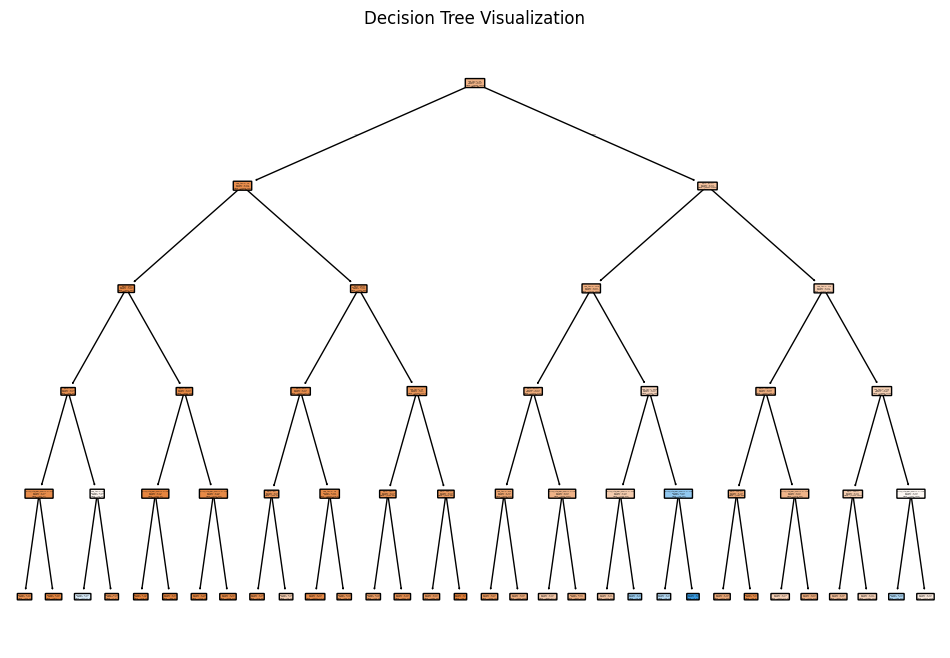

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Train a decision tree classifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)  # Using 'entropy' as the criterion
dt.fit(X_train, Y_train)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=['No', 'Yes'], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

#### **Text Representation**

In [ ]:
from sklearn import tree
from sklearn.tree import export_text

### Export the tree structure as text
tree_text = export_text(dt, feature_names=list(X_train.columns))

### Print the tree structure
print(tree_text)

|--- lead_time <= 8.50
|   |--- lead_time <= 1.50
|   |   |--- adr <= 12.50
|   |   |   |--- adr <= 7.00
|   |   |   |   |--- arrival_date_week_number <= 37.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- arrival_date_week_number >  37.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- adr >  7.00
|   |   |   |   |--- lead_time <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- lead_time >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- adr >  12.50
|   |   |   |--- adr <= 52.28
|   |   |   |   |--- arrival_date_week_number <= 6.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- arrival_date_week_number >  6.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- adr >  52.28
|   |   |   |   |--- arrival_date_week_number <= 15.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- arrival_date_week_number >  15.50
|   |   |   |   |   |--- class: 0
|   |--- lead_time >  1.50
|   |   |--- adr <= 75.34
|   |   |   |--- adr <= 24.00
|   |   |   |   |--

#### **Predicting the result**

In [ ]:
yhat = dt.predict(X_test)
yhat [0:5]

array([0, 0, 0, 0, 0])

#### **Accuracy evaluation**

In multilabel classification, the accuracy classification score calculates the subset accuracy, which measures how well the predicted labels match the actual labels in the test set. This score is equivalent to the Jaccard score, providing a way to assess the similarity between the predicted and true label sets.

In [ ]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, dt.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_test, yhat))

# Create a DataFrame to display the results
results_df = pd.DataFrame(X_test, columns=['lead_time', 'adr','arrival_date_week_number'])
results_df['True Label'] = Y_test.values
results_df['Predicted Label'] = yhat
results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']

# Display the first 15 observations
results_df.head(15)

Train set Accuracy:  0.7242510740980519
Test set Accuracy:  0.7242820150659134


lead_time     adr  arrival_date_week_number  True Label  \
57005          9   69.00                        10           0   
7168          44  302.11                        53           1   
41533        320  115.00                        34           1   
1246          11  199.40                        35           0   
71471         78  147.90                        49           0   
39746        118  120.00                        24           1   
31633          0  123.50                        28           0   
21822          7  140.00                        34           0   
38680         12  131.00                        18           1   
53898         75   65.00                        25           0   
35372        152   84.52                        40           0   
48956         38  160.00                        23           1   
5052         217  150.00                        29           1   
24006         17   66.00                        45           0   
75767        151   95.00                        12           0   

       Predicted Label  Correct  
57005                0     True  
7168                 0    False  
41533                0    False  
1246                 0     True  
71471                0     True  
39746                0    False  
31633                0     True  
21822                0     True  
38680                0    False  
53898                0     True  
35372                0     True  
48956                0    False  
5052                 0    False  
24006                0     True  
75767                0     True

### b. Confusion Metrix, accuracy, precision, recall, and f1 score

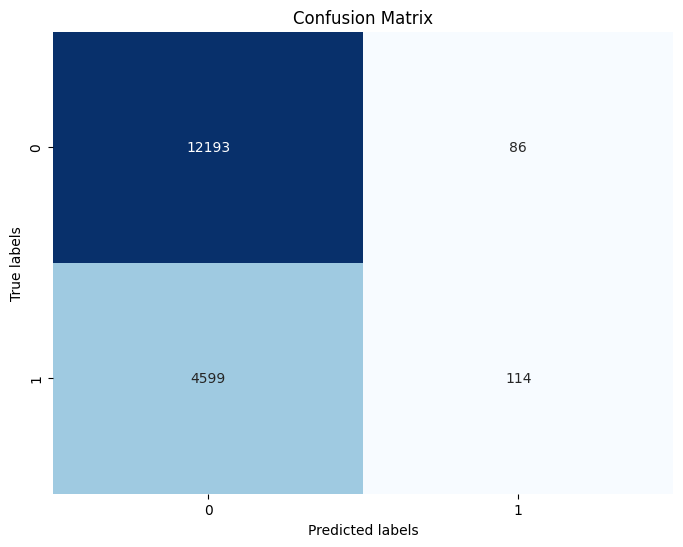

              precision    recall  f1-score   support

           0       0.73      0.99      0.84     12279
           1       0.57      0.02      0.05      4713

    accuracy                           0.72     16992
   macro avg       0.65      0.51      0.44     16992
weighted avg       0.68      0.72      0.62     16992

Accuracy: 0.7242820150659134
Precision: 0.57
Recall: 0.0241884150222788
F1 Score: 0.04640749033177285


In [ ]:


# Compute the confusion matrix
cm = confusion_matrix(Y_test, yhat)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Compute and print the classification report
report = classification_report(Y_test, yhat)
print(report)

# Calculate Accuracy
accuracy = accuracy_score(Y_test, yhat)

# Calculate Precision
precision = precision_score(Y_test, yhat)

# Calculate Recall
recall = recall_score(Y_test, yhat)

# Calculate F1 Score
f1 = f1_score(Y_test, yhat)

# Print the scores
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

### **c. Show and plot feature importance.**

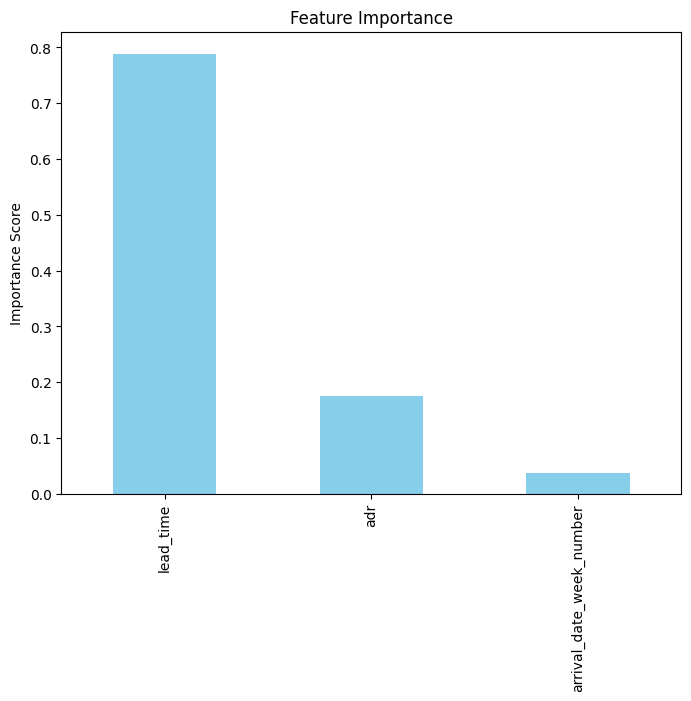

In [ ]:
# Feature Importance
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.show()

### **d. Precision_recall and ROC Curve**

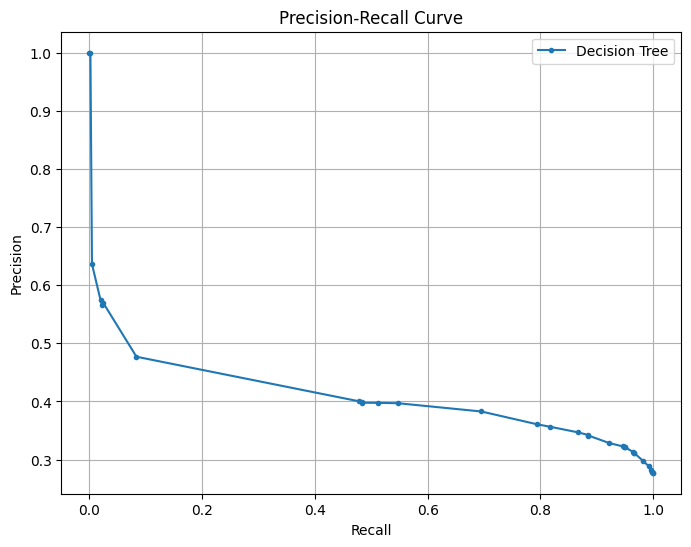

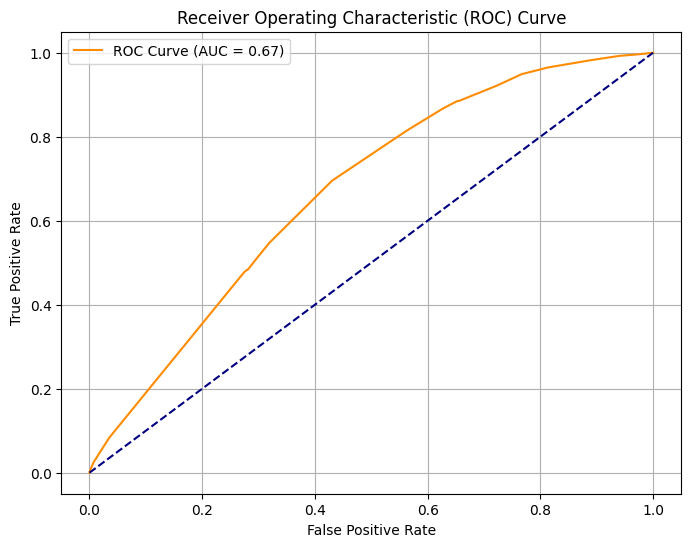

In [ ]:
# Import necessary libraries
from sklearn.metrics import precision_recall_curve # Import precision_recall_curve

# Precision-Recall Curve
y_probs = dt.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
precision, recall, _ = precision_recall_curve(Y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Decision Tree')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

# Import necessary libraries
from sklearn.metrics import roc_curve, auc # Import roc_curve and auc

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(Y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for reference
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

### **e. Use cross-validation (k=10) to show average accuracy**

In [ ]:
# Cross-Validation for Average Accuracy
cv_scores = cross_val_score(dt, X_train, Y_train, cv=10, scoring='accuracy')
average_accuracy = np.mean(cv_scores)

print(f"10-Fold Cross-Validation Accuracy: {average_accuracy:.2f}")

10-Fold Cross-Validation Accuracy: 0.72


#3.2 Pruning Techniques: Pre-pruning
- a1. Hyperparameter tuning:
Use grid search to find the best parameters.
Try the following options:
'max_depth': [5, 7, 10] (Test different tree depths)
'max_leaf_nodes': [10, 20, 30, 40] (Test different leaf nodes)
- a2. Visualization: Create a heatmap or line chart to show model performance across different parameters.
- a3. Report results: After selecting the best parameters, show (1) Confusion matrix, (2) Performance measures such as accuracy, recall, precision, and f1 value, and (3) Feature importance

## a1.Hyperparameter tuning
Perform hyperparameter tuning for the decision tree model.

### i. Pre-pruning Hyperparameter Tuning with GridSearchCV

Best Parameters: {'max_depth': 10, 'max_leaf_nodes': 40}
Best Cross-Validation Score: 0.72


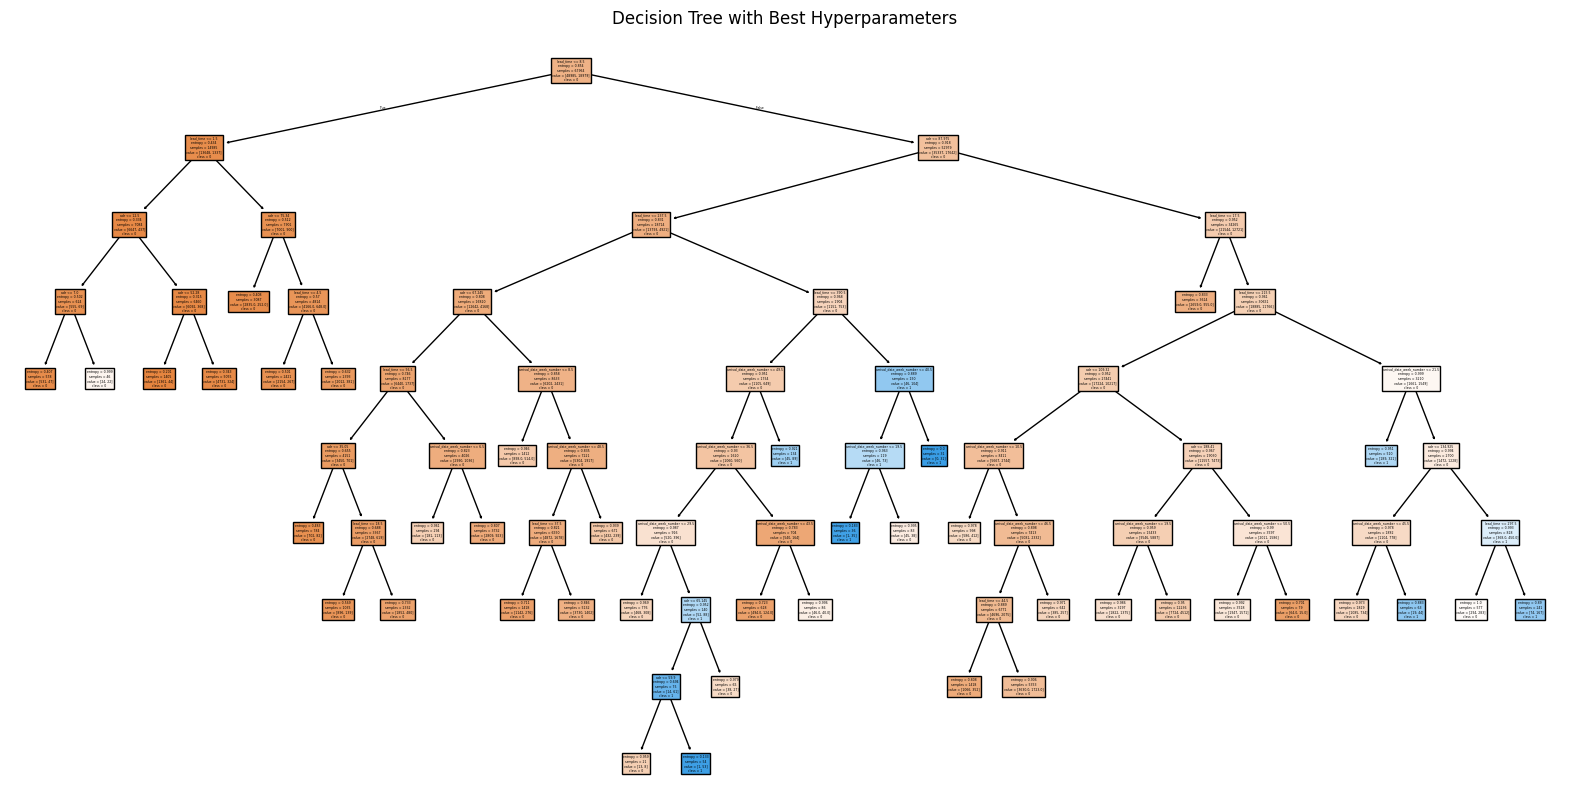

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [5, 7, 10],
    'max_leaf_nodes': [10, 20, 30, 40]
}

# Initialize a decision tree classifier
dt3 = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(dt3, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Print the best parameters and best score from grid search
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")

# Create a decision tree with the best parameters
prepruning_dt = DecisionTreeClassifier(**grid_search.best_params_, criterion='entropy', random_state=42)
prepruning_dt.fit(X_train, Y_train)

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Adjust the size of the plot as needed
plot_tree(prepruning_dt, filled=True, feature_names=X_train.columns, class_names=['0', '1'])
plt.title("Decision Tree with Best Hyperparameters")
plt.show()


## a2. Visualization: Create a heatmap to show model performance across different parameters.

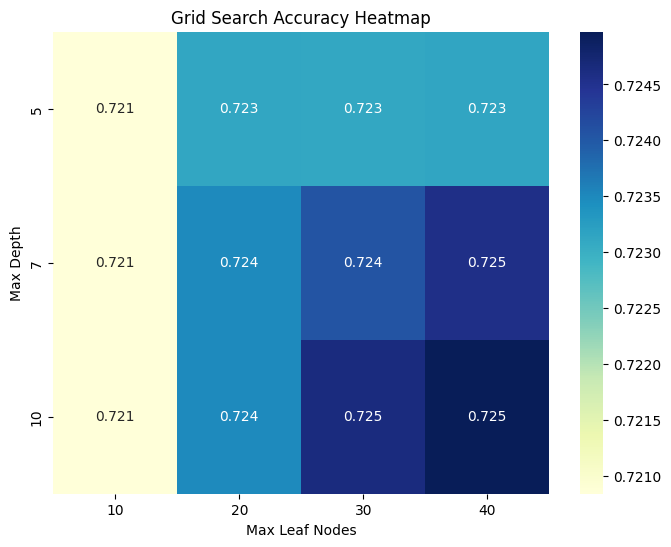

In [ ]:
# Visualization: Heatmap of Grid Search Results
results = pd.DataFrame(grid_search.cv_results_)
# Use keyword arguments for index, columns, and values
results_pivot = results.pivot(index="param_max_depth", columns="param_max_leaf_nodes", values="mean_test_score")

plt.figure(figsize=(8, 6))
sns.heatmap(results_pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Grid Search Accuracy Heatmap")
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Max Depth")
plt.show()

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, Y_train)

# Predict and evaluate the model
y_pred = best_model.predict(X_test)




## **a3. Report results**

Confusion Matrix:
[[12187    92]
 [ 4554   159]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.99      0.84     12279
           1       0.63      0.03      0.06      4713

    accuracy                           0.73     16992
   macro avg       0.68      0.51      0.45     16992
weighted avg       0.70      0.73      0.62     16992



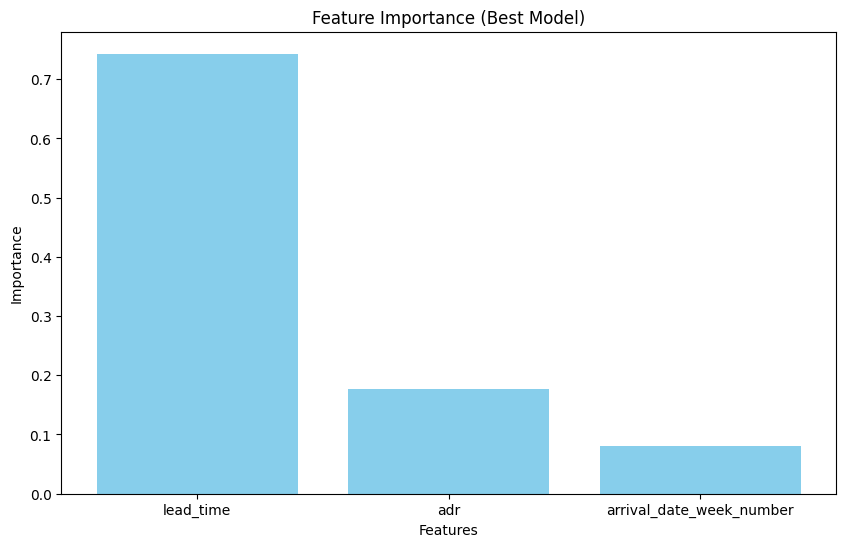

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Feature Importance
feature_importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importances, color='skyblue')
plt.title("Feature Importance (Best Model)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# **3.3 Other Models**
- K-Nearest Neighbors (KNN): Use KNN to classify the dataset. (No need to perform hyperparameter tuning.)
Report the confusion matrix and other performance measures. such as accuracy, recall, precision, and f1 value
- Logistic Regression: Use logistic regression to classify the dataset. (No need for hyperparameter tuning. If your model does not converge, try using the liblinear solver or other solvers.)
Report the confusion matrix and other performance measures. such as accuracy, recall, precision, and f1 value.

##a. K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Scale the data (KNN is distance-based and sensitive to feature scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, Y_train)

# Make predictions
yhat_knn = knn.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix (KNN):")
print(confusion_matrix(Y_test, yhat_knn))
print("\nClassification Report (KNN):")
print(classification_report(Y_test, yhat_knn))

# Calculate metrics
# These lines are added to calculate the metrics before printing
accuracy = accuracy_score(Y_test, yhat_knn)
precision = precision_score(Y_test, yhat_knn)
recall = recall_score(Y_test, yhat_knn)
f1 = f1_score(Y_test, yhat_knn)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Confusion Matrix (KNN):
[[10458  1821]
 [ 3287  1426]]

Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     12279
           1       0.44      0.30      0.36      4713

    accuracy                           0.70     16992
   macro avg       0.60      0.58      0.58     16992
weighted avg       0.67      0.70      0.68     16992

Accuracy: 0.70
Precision: 0.44
Recall: 0.30
F1 Score: 0.36


##b. Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model
print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(Y_test, yhat_log_reg))

print("\nClassification Report (Logistic Regression):")
print(classification_report(Y_test, yhat_log_reg))

# Calculate individual metrics
accuracy = accuracy_score(Y_test, yhat_log_reg)
precision = precision_score(Y_test, yhat_log_reg, average='binary')  # Use 'binary' for binary classification
recall = recall_score(Y_test, yhat_log_reg, average='binary')
f1 = f1_score(Y_test, yhat_log_reg, average='binary')

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Confusion Matrix (Logistic Regression):
[[11932   347]
 [ 4403   310]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.73      0.97      0.83     12279
           1       0.47      0.07      0.12      4713

    accuracy                           0.72     16992
   macro avg       0.60      0.52      0.47     16992
weighted avg       0.66      0.72      0.63     16992

Accuracy: 0.72
Precision: 0.47
Recall: 0.07
F1 Score: 0.12


# **Conclusions**
- 4.1 Best Model: Among pre-pruning, KNN, and Logistic Regression, which one gives you the best accuracy? Which one gives you the best recall? Which one gives you the best precision? What measures will you use to determine the final model? Describe your choice, results, and reasoning.

- 4.2. Managerial Implications: What insights can you provide to managers if you use decision tree? For instance, interpret the feature importance from the decision tree.

### **4.1 Best Model: Pre-Pruning, KNN, Logistic Regression**


### a.  **Comparison of Metrics**

Here’s the comparison of **Logistic Regression**, **KNN**, and **Decision Tree** models in a markdown table format, showing the metrics in percentages:

---

### Model Comparison Table

| Metric                     | Logistic Regression (%) | KNN (%) | Pre Pruning (%) |
|----------------------------|--------------------------|---------|--------------------|
| **Accuracy**               | 72                      | 70      | 73                 |
| **Precision**    | 47                     | 44     | 63                |
| **Recall**    | 7                      | 30      | 03               |
| **F1**       | 12                      | 36      | 06                 |
                |



### b. **Evaluation**
### **Comparison of Models: Logistic Regression, KNN, and Pre-Pruning Decision Tree**

#### **Best Metrics**
1. **Best Accuracy**:
   - **Pre-Pruning Decision Tree**: **73%**
     - Slightly outperforms Logistic Regression (72%) and KNN (70%).
     - Indicates good overall prediction performance.

2. **Best Recall**:
   - **KNN**: **30%**
     - Performs significantly better in identifying cancellations (class `1`) compared to Logistic Regression (7%) and Pre-Pruning Decision Tree (3%).
     - Critical for minimizing false negatives (missed cancellations).

3. **Best Precision**:
   - **Pre-Pruning Decision Tree**: **63%**
     - Outperforms Logistic Regression (47%) and KNN (44%) in predicting cancellations accurately.
     - Indicates fewer false positives (incorrectly predicting cancellations).

---







### c. **Final Choice**
- **Chosen Model**: KNN

KNN is the best model because it achieves the **highest recall for class 1 (30%)**, making it more effective at identifying cancellations compared to Logistic Regression (7%) and the Pre-Pruning Decision Tree (3%). This is crucial for minimizing missed cancellations, which can lead to overbooking and revenue losses. Additionally, KNN balances recall with acceptable precision (44%) and a competitive F1-score (36%), providing better performance in handling cancellations while maintaining reasonable accuracy (70%). Its ability to model nonlinear relationships further justifies its selection over simpler models like Logistic Regression or Decision Tree.



### d. **Recommendations**
1. Improve predictive power by adding or transforming features.
2. Address class imbalance using techniques like oversampling or class weighting.
3. Experiment with ensemble methods (e.g., Random Forest or Gradient Boosting).
